Epoch 1/150


C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['ul_input', 'dl_input', 'temporal_input', 'protocol_input']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


282/282 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - dl_flow_output_loss: 0.8120 - loss: 3.2937 - protocol_output_loss: 0.7733 - temporal_output_loss: 0.7794 - ul_flow_output_loss: 0.9289 - val_dl_flow_output_loss: 0.1605 - val_loss: 0.8174 - val_protocol_output_loss: 0.3932 - val_temporal_output_loss: 0.0734 - val_ul_flow_output_loss: 0.1940 - learning_rate: 0.0010
Epoch 2/150
282/282 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - dl_flow_output_loss: 0.1398 - loss: 0.5653 - protocol_output_loss: 0.1410 - temporal_output_loss: 0.1145 - ul_flow_output_loss: 0.1700 - val_dl_flow_output_loss: 0.0357 - val_loss: 0.4293 - val_protocol_output_loss: 0.3015 - val_temporal_output_loss: 0.0378 - val_ul_flow_output_loss: 0.0562 - learning_rate: 0.0010
Epoch 3/150
282/282 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - dl_flow_output_loss: 0.1233 - loss: 0.4197 - protocol_output_loss: 0.0891 - temporal_output_loss: 0.0879 - ul_flow_output_loss: 0.1194 - val_dl_flow_output_loss: 0.0205 - val_loss: 0.3955 - val_protocol_output_l

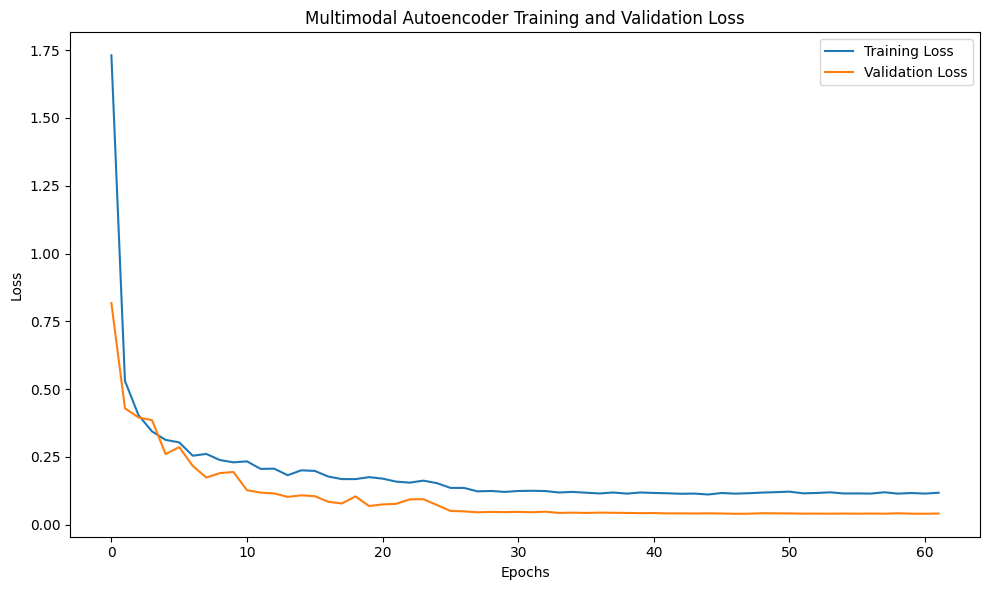

706/706 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

Classification Performance Metrics:
Accuracy: 0.8199
Precision (Weighted): 0.8204
Recall (Weighted): 0.8199
F1 Score (Weighted): 0.8196

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       326
           1       0.75      0.80      0.78       285
           2       0.79      0.82      0.81       350
           3       0.84      0.89      0.86       328
           4       0.83      0.79      0.81       301
           5       0.82      0.84      0.83       328
           6       0.77      0.83      0.80       313
           7       0.87      0.88      0.87       324
           8       0.85      0.78      0.81       317
           9       0.79      0.79      0.79       336
          10       0.75      0.73      0.74       284
          11       0.84      0.83      0.83       344
          12       0.85      0.76      0.80       329
          13       0.83      0.80      0.

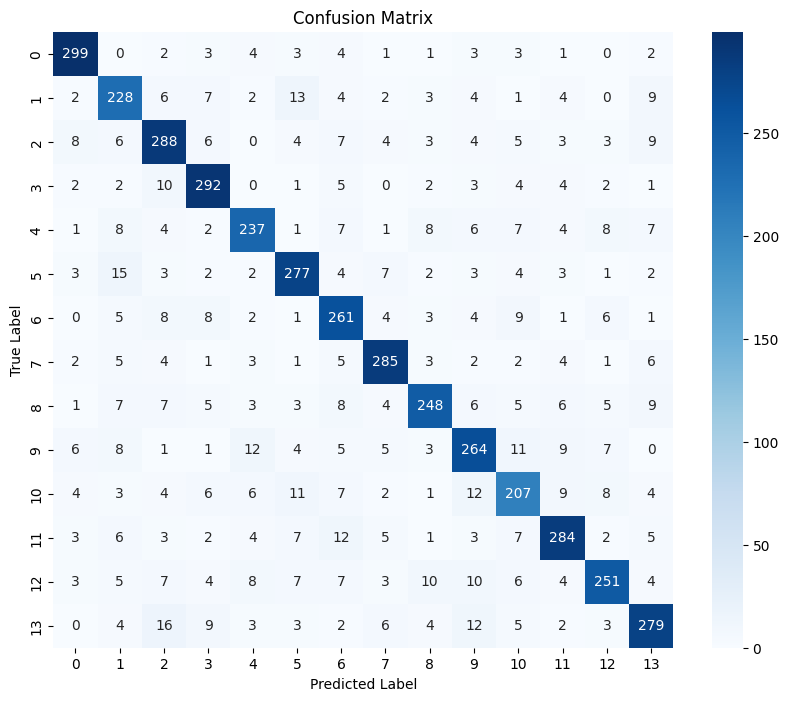

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    classification_report,
    ConfusionMatrixDisplay
)

def preprocess_features(data):
    # Separate features
    ul_flow_features = ['ul_total_num_pkts', 'ul_total_num_bytes', 'ul_min_pkt_size', 
                       'ul_max_pkt_size', 'ul_mean_pkt_size', 'ul_std_pkt_size']
    
    dl_flow_features = ['dl_total_num_pkts', 'dl_total_num_bytes', 'dl_min_pkt_size', 
                       'dl_max_pkt_size', 'dl_mean_pkt_size', 'dl_std_pkt_size']
    
    temporal_features = ['ul_min_iat', 'ul_max_iat', 'ul_mean_iat', 'ul_std_iat', 'ul_dur',
                        'dl_min_iat', 'dl_max_iat', 'dl_mean_iat', 'dl_std_iat', 'dl_dur']
    
    # Feature engineering
    data['ul_byte_pkt_ratio'] = data['ul_total_num_bytes'] / (data['ul_total_num_pkts'] + 1e-6)
    data['dl_byte_pkt_ratio'] = data['dl_total_num_bytes'] / (data['dl_total_num_pkts'] + 1e-6)
    data['total_duration'] = data['ul_dur'] + data['dl_dur']
    data['pkt_ratio'] = data['ul_total_num_pkts'] / (data['dl_total_num_pkts'] + 1e-6)
    
    # Log transform temporal features
    for col in temporal_features:
        data[col] = np.log1p(data[col])
    
    # IP address processing
    data['ip_A'] = data['ip_A'].astype(str).apply(lambda x: int(x.split('.')[-1]))
    data['ip_B'] = data['ip_B'].astype(str).apply(lambda x: int(x.split('.')[-1]))
    
    # Protocol one-hot encoding
    protocol_encoder = OneHotEncoder(sparse_output=False)
    protocol_encoded = protocol_encoder.fit_transform(data[['protocal']])
    protocol_df = pd.DataFrame(protocol_encoded, 
                             columns=[f'protocol_{i}' for i in range(protocol_encoded.shape[1])])
    
    # Combine features
    feature_sets = {
        'ul_flow': ul_flow_features + ['ul_byte_pkt_ratio'],
        'dl_flow': dl_flow_features + ['dl_byte_pkt_ratio'],
        'temporal': temporal_features + ['total_duration'],
        'protocol': ['ip_A', 'ip_B', 'port_A', 'port_B'] + [f'protocol_{i}' for i in range(protocol_encoded.shape[1])]
    }
    
    # Scale features
    scalers = {}
    scaled_features = {}
    
    for name, feature_list in feature_sets.items():
        if name == 'protocol':
            features = pd.concat([data[['ip_A', 'ip_B', 'port_A', 'port_B']], protocol_df], axis=1)
        else:
            features = data[feature_list]
        
        scalers[name] = StandardScaler()
        scaled_features[name] = scalers[name].fit_transform(features)
    
    return scaled_features, scalers, protocol_encoder

def create_enhanced_autoencoder(input_sizes):
    inputs = {
        'ul_flow': Input(shape=(input_sizes['ul_flow'],), name="ul_input"),
        'dl_flow': Input(shape=(input_sizes['dl_flow'],), name="dl_input"),
        'temporal': Input(shape=(input_sizes['temporal'],), name="temporal_input"),
        'protocol': Input(shape=(input_sizes['protocol'],), name="protocol_input")
    }
    
    encoded = {}
    for name, input_layer in inputs.items():
        x = Dense(256, activation='relu')(input_layer)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        x = Dense(128, activation='relu')(x)
        x = BatchNormalization()(x)
        encoded[name] = Dropout(0.3)(x)
    
    combined = Concatenate()(list(encoded.values()))
    
    latent = Dense(256, activation='relu', name="latent_space")(combined)
    latent = BatchNormalization()(latent)
    latent = Dropout(0.4)(latent)
    
    decoded = {}
    for name, input_size in input_sizes.items():
        x = Dense(128, activation='relu')(latent)
        x = BatchNormalization()(x)
        x = Dense(256, activation='relu')(x)
        x = BatchNormalization()(x)
        decoded[name] = Dense(input_size, activation='linear', name=f"{name}_output")(x)
    
    autoencoder = Model(
        inputs=list(inputs.values()),
        outputs=list(decoded.values())
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    losses = {f"{name}_output": 'mean_squared_error' for name in input_sizes.keys()}
    autoencoder.compile(optimizer=optimizer, loss=losses)
    
    return autoencoder

def train_model(data_path):
    data = pd.read_csv(data_path)
    labels = data['app']
    
    scaled_features, scalers, protocol_encoder = preprocess_features(data)
    input_sizes = {name: features.shape[1] for name, features in scaled_features.items()}
    
    autoencoder = create_enhanced_autoencoder(input_sizes)
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    ]
    
    history = autoencoder.fit(
        list(scaled_features.values()),
        list(scaled_features.values()),
        epochs=150,
        batch_size=64,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=1
    )

     # Plot the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Multimodal Autoencoder Training and Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()
    
    encoder = Model(
        inputs=autoencoder.inputs,
        outputs=autoencoder.get_layer('latent_space').output
    )
    
    latent_features = encoder.predict(list(scaled_features.values()))
    
    X_train, X_test, y_train, y_test = train_test_split(
        latent_features, labels, test_size=0.2, random_state=42
    )
    
    rf_classifier = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        bootstrap=True,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    rf_classifier.fit(X_train, y_train)
    
    y_pred = rf_classifier.predict(X_test)

     # Calculate metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision (Weighted)': precision_score(y_test, y_pred, average='weighted'),
        'Recall (Weighted)': recall_score(y_test, y_pred, average='weighted'),
        'F1 Score (Weighted)': f1_score(y_test, y_pred, average='weighted')
    }
    
    # Print metrics
    print("\nClassification Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    autoencoder.save('enhanced_autoencoder.h5')
    joblib.dump(rf_classifier, 'rf_classifier.pkl')
    joblib.dump(scalers, 'scalers.pkl')
    joblib.dump(protocol_encoder, 'protocol_encoder.pkl')
    
    return autoencoder, rf_classifier, scalers, protocol_encoder

if __name__ == "__main__":
    autoencoder, rf_classifier, scalers, protocol_encoder = train_model('balanced_random_smoteenn.csv')

C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['ul_input', 'dl_input', 'temporal_input', 'protocol_input']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

Model Performance Metrics:
Accuracy: 0.9671
Precision: 0.9672
Recall: 0.9671
F1 Score: 0.9671

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        50
           1       0.94      0.96      0.95        50
           2       0.98      0.98      0.98        50
           3       1.00      1.00      1.00        50
           4       0.96      0.92      0.94        50
           5       0.96      0.98      0.97        50
           6       0.94      0.94      0.94        50
           7       0.94      0.96      0.95        50
           8       1.00      1.00      1.00        50
           9       0.98      0.98      0.98        50
          10       0.98      0.94      0.96        50
          11       0.94      0.92      0.93        50
          12       0.98      1.00      0.99        50
          13       0.96      0.98      0.97        50

    accuracy        

<Figure size 1200x500 with 0 Axes>

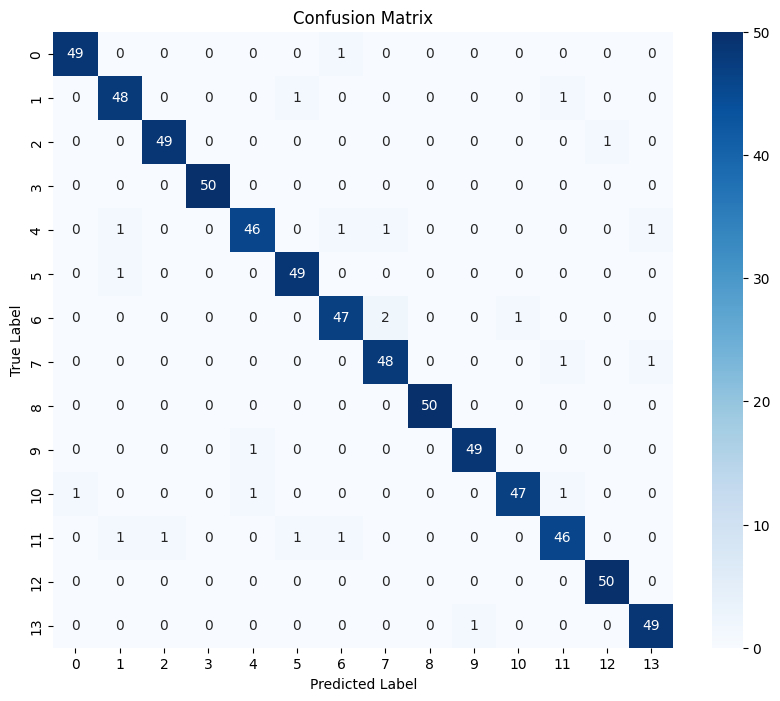

In [49]:
def evaluate_model(test_data_path, autoencoder_path, rf_path, scalers_path, protocol_encoder_path):
    # Load models and scalers
    autoencoder = tf.keras.models.load_model(autoencoder_path)
    rf_classifier = joblib.load(rf_path)
    scalers = joblib.load(scalers_path)
    protocol_encoder = joblib.load(protocol_encoder_path)
    
    # Load and preprocess test data
    test_data = pd.read_csv(test_data_path)
    test_labels = test_data['app']
    
    # Preprocess features using loaded scalers
    scaled_features = {}

    # Protocol encoding
    protocol_encoded = protocol_encoder.transform(test_data[['protocal']])
    protocol_df = pd.DataFrame(protocol_encoded, 
                             columns=[f'protocol_{i}' for i in range(protocol_encoded.shape[1])])
    
    # Process IP addresses
    test_data['ip_A'] = test_data['ip_A'].astype(str).apply(lambda x: int(x.split('.')[-1]))
    test_data['ip_B'] = test_data['ip_B'].astype(str).apply(lambda x: int(x.split('.')[-1]))
    
    # Feature engineering
    test_data['ul_byte_pkt_ratio'] = test_data['ul_total_num_bytes'] / (test_data['ul_total_num_pkts'] + 1e-6)
    test_data['dl_byte_pkt_ratio'] = test_data['dl_total_num_bytes'] / (test_data['dl_total_num_pkts'] + 1e-6)
    test_data['total_duration'] = test_data['ul_dur'] + test_data['dl_dur']
    
    # Log transform temporal features
    temporal_features = ['ul_min_iat', 'ul_max_iat', 'ul_mean_iat', 'ul_std_iat', 'ul_dur',
                        'dl_min_iat', 'dl_max_iat', 'dl_mean_iat', 'dl_std_iat', 'dl_dur']
    for col in temporal_features:
        test_data[col] = np.log1p(test_data[col])
    
    # Define feature sets
    feature_sets = {
        'ul_flow': ['ul_total_num_pkts', 'ul_total_num_bytes', 'ul_min_pkt_size', 
                    'ul_max_pkt_size', 'ul_mean_pkt_size', 'ul_std_pkt_size', 'ul_byte_pkt_ratio'],
        'dl_flow': ['dl_total_num_pkts', 'dl_total_num_bytes', 'dl_min_pkt_size', 
                    'dl_max_pkt_size', 'dl_mean_pkt_size', 'dl_std_pkt_size', 'dl_byte_pkt_ratio'],
        'temporal': temporal_features + ['total_duration'],
        'protocol': ['ip_A', 'ip_B', 'port_A', 'port_B']
    }
    
    # Scale features using loaded scalers
    for name, feature_list in feature_sets.items():
        if name == 'protocol':
            features = pd.concat([test_data[feature_list], protocol_df], axis=1)
        else:
            features = test_data[feature_list]
        scaled_features[name] = scalers[name].transform(features)
    
    # Get latent representation
    encoder = Model(inputs=autoencoder.inputs,
                   outputs=autoencoder.get_layer('latent_space').output)
    latent_features = encoder.predict(list(scaled_features.values()))
    
    # Make predictions
    predictions = rf_classifier.predict(latent_features)
    
    # Calculate metrics
    metrics = {
        'Accuracy': accuracy_score(test_labels, predictions),
        'Precision': precision_score(test_labels, predictions, average='weighted'),
        'Recall': recall_score(test_labels, predictions, average='weighted'),
        'F1 Score': f1_score(test_labels, predictions, average='weighted')
    }
    
    # Generate plots
    plt.figure(figsize=(12, 5))
    
    # Confusion Matrix
    cm = confusion_matrix(test_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix(test_labels, predictions), annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Print classification report
    report = classification_report(test_labels, predictions)
    
    return metrics, report, cm

# Usage example:
if __name__ == "__main__":
    metrics, report, cm = evaluate_model(
        'test_dataset.csv',
        'enhanced_autoencoder.h5',
        'rf_classifier.pkl',
        'scalers.pkl',
        'protocol_encoder.pkl'
    )
    
    # Print results
    print("\nModel Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print("\nDetailed Classification Report:")
    print(report)
    
    plt.show()

C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['ul_input', 'dl_input', 'temporal_input', 'protocol_input']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

Model Performance Metrics:
Accuracy: 0.8243
Precision: 0.8283
Recall: 0.8243
F1 Score: 0.8242

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.82      0.88        50
           1       0.89      0.80      0.84        50
           2       0.73      0.76      0.75        50
           3       0.83      0.86      0.84        50
           4       0.93      0.84      0.88        50
           5       0.84      0.74      0.79        50
           6       0.85      0.80      0.82        50
           7       0.78      0.86      0.82        50
           8       0.77      0.74      0.76        50
           9       0.76      0.90      0.83        50
          10       0.76      0.78      0.77        50
          11       0.84      0.92      0.88        50
          12       0.83      0.78      0.80        50
          13       0.82      0.94      0.88        50

    accuracy        

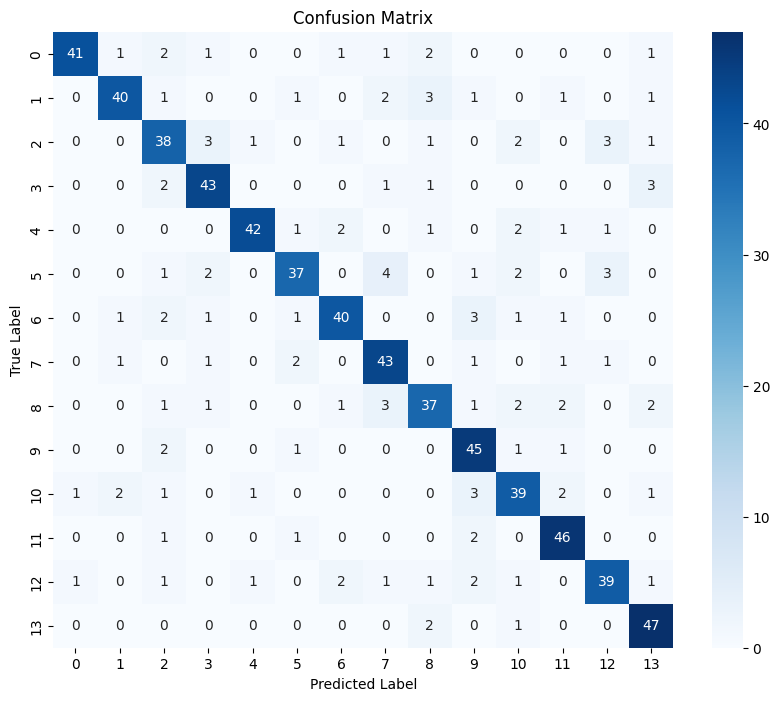

In [47]:
import tensorflow as tf
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(test_data_path, autoencoder_path, rf_path, scalers_path, protocol_encoder_path):
    # Load models and scalers
    autoencoder = tf.keras.models.load_model(autoencoder_path)
    rf_classifier = joblib.load(rf_path)
    scalers = joblib.load(scalers_path)
    protocol_encoder = joblib.load(protocol_encoder_path)
    
    # Load and preprocess test data
    test_data = pd.read_csv(test_data_path)
    test_labels = test_data['app']
    
    # Preprocess features using loaded scalers
    scaled_features = {}

    # Filter known protocol categories
    known_categories = protocol_encoder.categories_[0]
    test_data = test_data[test_data['protocal'].isin(known_categories)]
    
    # Protocol encoding
    protocol_encoded = protocol_encoder.transform(test_data[['protocal']])
    protocol_df = pd.DataFrame(protocol_encoded, 
                               columns=[f'protocol_{i}' for i in range(protocol_encoded.shape[1])])
    
    # Process IP addresses
    test_data['ip_A'] = test_data['ip_A'].astype(str).apply(lambda x: int(x.split('.')[-1]))
    test_data['ip_B'] = test_data['ip_B'].astype(str).apply(lambda x: int(x.split('.')[-1]))
    
    # Feature engineering
    test_data['ul_byte_pkt_ratio'] = test_data['ul_total_num_bytes'] / (test_data['ul_total_num_pkts'] + 1e-6)
    test_data['dl_byte_pkt_ratio'] = test_data['dl_total_num_bytes'] / (test_data['dl_total_num_pkts'] + 1e-6)
    test_data['total_duration'] = test_data['ul_dur'] + test_data['dl_dur']
    
    # Log transform temporal features
    temporal_features = ['ul_min_iat', 'ul_max_iat', 'ul_mean_iat', 'ul_std_iat', 'ul_dur',
                         'dl_min_iat', 'dl_max_iat', 'dl_mean_iat', 'dl_std_iat', 'dl_dur']
    for col in temporal_features:
        test_data[col] = np.log1p(test_data[col])
    
    # Define feature sets
    feature_sets = {
        'ul_flow': ['ul_total_num_pkts', 'ul_total_num_bytes', 'ul_min_pkt_size', 
                    'ul_max_pkt_size', 'ul_mean_pkt_size', 'ul_std_pkt_size', 'ul_byte_pkt_ratio'],
        'dl_flow': ['dl_total_num_pkts', 'dl_total_num_bytes', 'dl_min_pkt_size', 
                    'dl_max_pkt_size', 'dl_mean_pkt_size', 'dl_std_pkt_size', 'dl_byte_pkt_ratio'],
        'temporal': temporal_features + ['total_duration'],
        'protocol': ['ip_A', 'ip_B', 'port_A', 'port_B']
    }
    
    # Scale features using loaded scalers
    for name, feature_list in feature_sets.items():
        if name == 'protocol':
            features = pd.concat([test_data[feature_list], protocol_df], axis=1)
        else:
            features = test_data[feature_list]
        scaled_features[name] = scalers[name].transform(features)
    
    # Ensure all feature arrays have the same number of samples
    min_samples = min(features.shape[0] for features in scaled_features.values())
    for name in scaled_features:
        scaled_features[name] = scaled_features[name][:min_samples]
    test_labels = test_labels.iloc[:min_samples]
    
    # Get latent representation
    encoder = Model(inputs=autoencoder.inputs, outputs=autoencoder.get_layer('latent_space').output)
    latent_features = encoder.predict([scaled_features[name] for name in feature_sets.keys()])
    
    # Make predictions
    predictions = rf_classifier.predict(latent_features)
    
    # Calculate metrics
    metrics = {
        'Accuracy': accuracy_score(test_labels, predictions),
        'Precision': precision_score(test_labels, predictions, average='weighted'),
        'Recall': recall_score(test_labels, predictions, average='weighted'),
        'F1 Score': f1_score(test_labels, predictions, average='weighted')
    }
    
    
    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(test_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Print classification report
    report = classification_report(test_labels, predictions)
    
    return metrics, report, cm

# Usage example
if __name__ == "__main__":
    metrics, report, cm = evaluate_model(
        'test_dataset.csv',
        'enhanced_autoencoder.h5',
        'rf_classifier.pkl',
        'scalers.pkl',
        'protocol_encoder.pkl'
    )
    
    # Print results
    print("\nModel Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print("\nDetailed Classification Report:")
    print(report)
    
    plt.show()


In [48]:
import pandas as pd

def sample_instances_per_class(dataframe, class_column, num_instances=50):
    """
    Samples a specified number of instances for each class in a dataset.

    :param dataframe: pandas DataFrame, the input dataset.
    :param class_column: str, the column name containing class labels.
    :param num_instances: int, the number of instances to sample per class.
    :return: pandas DataFrame containing the sampled instances.
    """
    sampled_data = dataframe.groupby(class_column).apply(
        lambda group: group.sample(n=num_instances, random_state=42, replace=len(group) < num_instances)
    ).reset_index(drop=True)
    
    return sampled_data

# Example usage:
# Load your dataset
data = pd.read_csv("balanced_random_smoteenn.csv")

# Column name containing class labels
class_column = "app"  # Replace with the name of your class column

# Sample 50 instances per class
sampled_data = sample_instances_per_class(data, class_column, num_instances=50)

# Save the sampled data to a new CSV file if needed
sampled_data.to_csv("test_dataset.csv", index=False)

print(f"Sampled dataset created with {len(sampled_data)} rows.")


Sampled dataset created with 700 rows.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11580\1275037885.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = dataframe.groupby(class_column).apply(
